# PNEUMONIA DETECTION USING CNN

# ~Importing Necessary Libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, confusion_matrix


# ~Dataset Preparation

In [2]:
train_dir = 'D:/chest_xray/train'
val_dir = 'D:/chest_xray/val'
test_dir = 'D:/chest_xray/test'


# ~Visualizing Sample Images

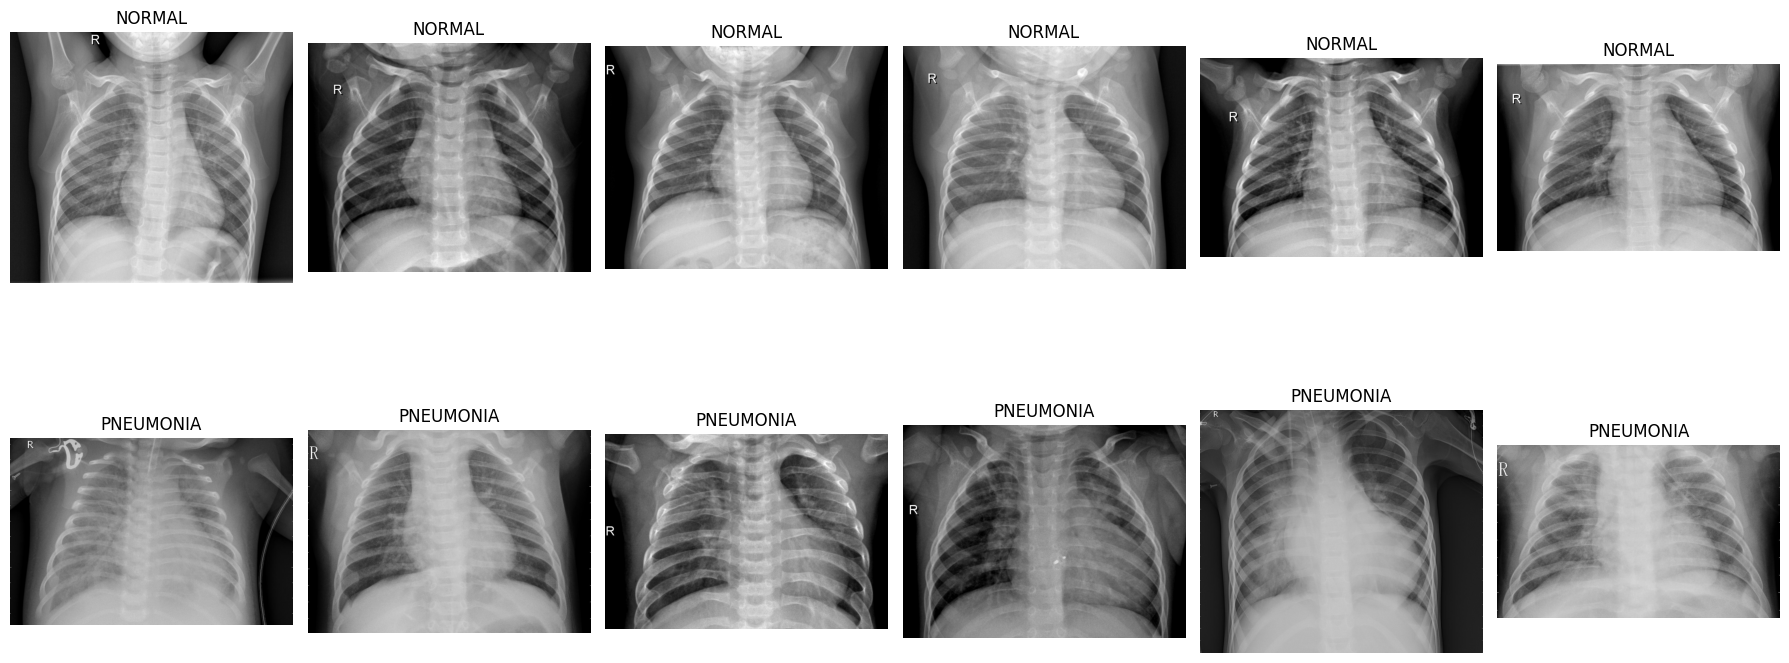

In [3]:
import os
import matplotlib.pyplot as plt

normal_dir = os.path.join(train_dir,'NORMAL')
pneumonia_dir = os.path.join(train_dir,'PNEUMONIA')

normal_images = os.listdir(normal_dir)
pneumonia_images = os.listdir(pneumonia_dir)

# Plotting NORMAL images
plt.figure(figsize=(18, 9))
for i in range(6):
    img_path = os.path.join(normal_dir, normal_images[i])
    img = plt.imread(img_path)
    plt.subplot(2, 6, i+1)
    plt.imshow(img, cmap='gray')
    plt.title("NORMAL")
    plt.axis('off')

# Plotting PNEUMONIA images
for i in range(6):
    img_path = os.path.join(pneumonia_dir, pneumonia_images[i])
    img = plt.imread(img_path)
    plt.subplot(2, 6, i+7)
    plt.imshow(img, cmap='gray')
    plt.title("PNEUMONIA")
    plt.axis('off')

plt.tight_layout()
plt.show()

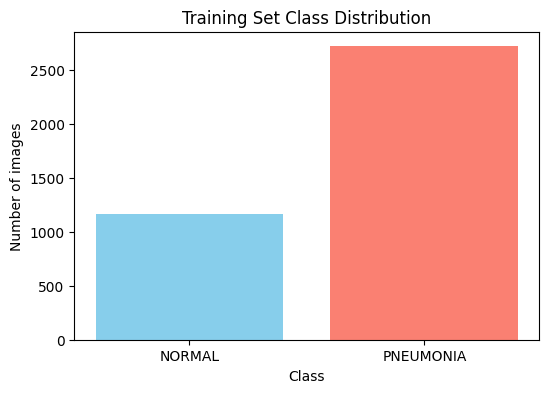

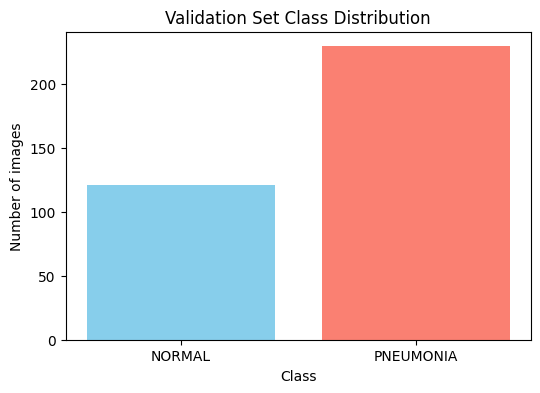

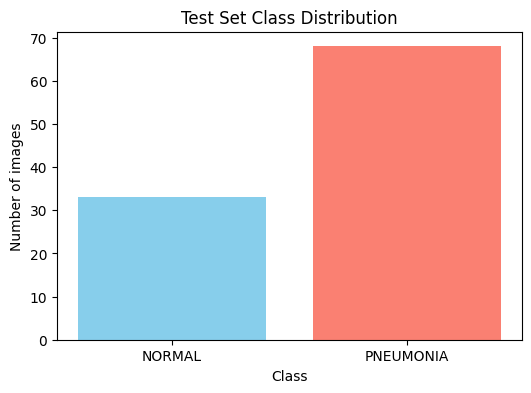

In [4]:
def plot_class_distribution(directory, title):
    categories = ['NORMAL', 'PNEUMONIA']
    counts = [len(os.listdir(os.path.join(directory, category))) for category in categories]

    plt.figure(figsize=(6,4))
    plt.bar(categories, counts, color=['skyblue','salmon'])
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Number of images')
    plt.show()

# Plot for each set
plot_class_distribution(train_dir, 'Training Set Class Distribution')
plot_class_distribution(val_dir, 'Validation Set Class Distribution')
plot_class_distribution(test_dir, 'Test Set Class Distribution')


# ~Data Preprocessing and Augmentation

In [5]:
img_size = (150, 150)
batch_size = 16

# Training generator with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True
)

# Validation & test generators without augmentation
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Loading training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    color_mode='grayscale' 
)

# Loading validation data
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    color_mode='grayscale'
)

# Loading test data
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=False  # important for confusion matrix
)

Found 3887 images belonging to 2 classes.
Found 350 images belonging to 2 classes.
Found 101 images belonging to 2 classes.


# ~Visualizing Sample Augmented Images

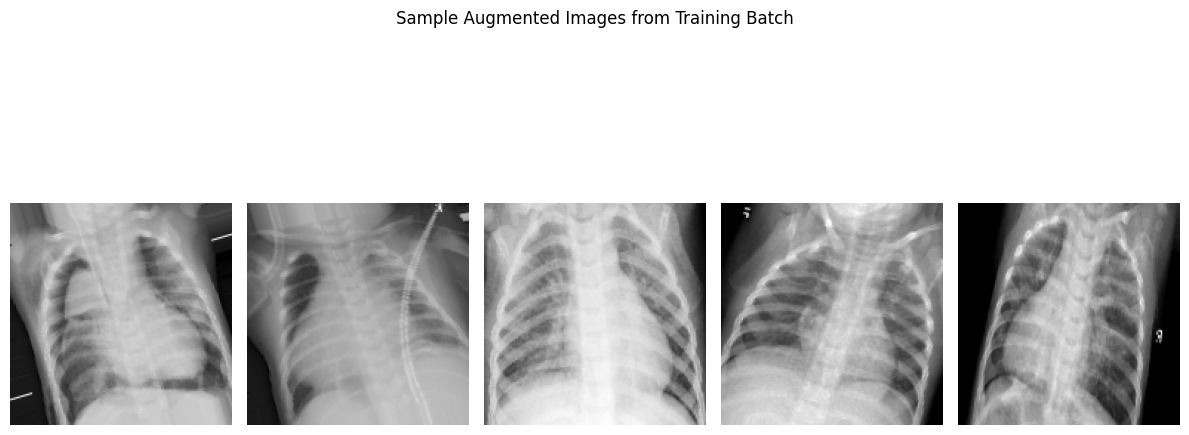

In [6]:
# Get a batch of augmented images from training data
images, labels = next(train_generator)

# Plot images in the batch
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i].reshape(150, 150), cmap='gray')
    plt.axis('off')
plt.suptitle("Sample Augmented Images from Training Batch")
plt.tight_layout()
plt.show()


# ~Building and Compiling the CNN Model

In [7]:
from tensorflow.keras.optimizers import SGD

model = Sequential()

# 1. First Convolutional Layer + Pooling
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))  # grayscale image
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# 2. Second Convolutional Layer + Pooling
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())

model.add(Dropout(0.5))

# Output Layer
model.add(Dense(1, activation='sigmoid'))  # binary classification (0 or 1)

model.compile(optimizer=SGD(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 148, 148, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 72, 72, 64)       256       
 hNormalization)                                                 
                                                        

# Training the model

In [36]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,  
    epochs=10, 
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,  
)

Epoch 1/10
242/242 [==============================] - 175s 723ms/step - loss: 0.2078 - accuracy: 0.9199 - val_loss: 0.3615 - val_accuracy: 0.8690
Epoch 2/10
242/242 [==============================] - 130s 538ms/step - loss: 0.2083 - accuracy: 0.9166 - val_loss: 0.3450 - val_accuracy: 0.8452
Epoch 3/10
242/242 [==============================] - 126s 521ms/step - loss: 0.1959 - accuracy: 0.9217 - val_loss: 0.2685 - val_accuracy: 0.9137
Epoch 4/10
242/242 [==============================] - 121s 500ms/step - loss: 0.1977 - accuracy: 0.9199 - val_loss: 0.4619 - val_accuracy: 0.8214
Epoch 5/10
242/242 [==============================] - 120s 496ms/step - loss: 0.1840 - accuracy: 0.9308 - val_loss: 0.2391 - val_accuracy: 0.9077
Epoch 6/10
242/242 [==============================] - 117s 482ms/step - loss: 0.1745 - accuracy: 0.9318 - val_loss: 0.2023 - val_accuracy: 0.9196
Epoch 7/10
242/242 [==============================] - 124s 515ms/step - loss: 0.1708 - accuracy: 0.9336 - val_loss: 0.2582 -

# ~Evaluating Model Performance

In [39]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print("Test Loss: " , test_loss)
print("Test Accuracy: " , test_accuracy)


6/6 [==============================] - 1s 136ms/step - loss: 0.1189 - accuracy: 0.9583
Test Loss:  0.11891553550958633
Test Accuracy:  0.9583333134651184


~Visualizing Training Progress

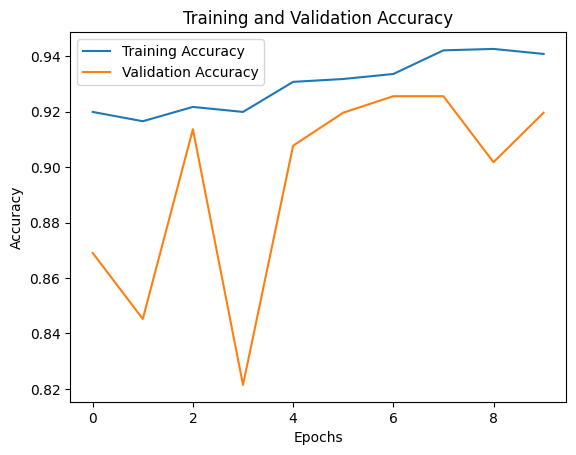

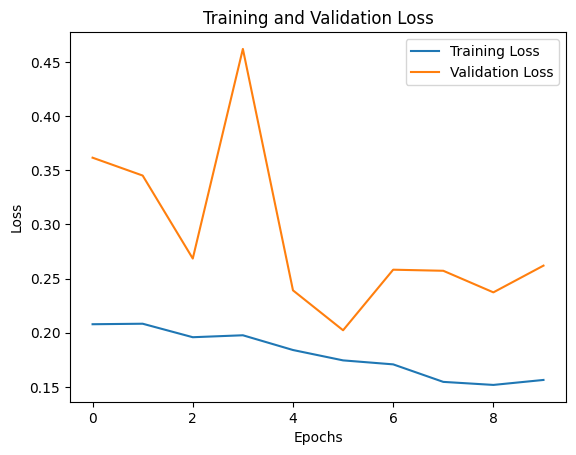

In [40]:
import matplotlib.pyplot as plt

# Plotting training & validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [11]:
# Getting True labels from the test data
test_generator.reset()  
true_classes = []
for i in range(test_generator.samples // batch_size):
    images, labels = next(test_generator)
    true_classes.extend(labels) 

# Making predictions on the test data
predictions = model.predict(test_generator, steps=test_generator.samples // batch_size)
predicted_classes = (predictions > 0.5).astype("int32").flatten() 


6/6 [==============================] - 2s 269ms/step


# ~Confusion Matrix and Classification Report

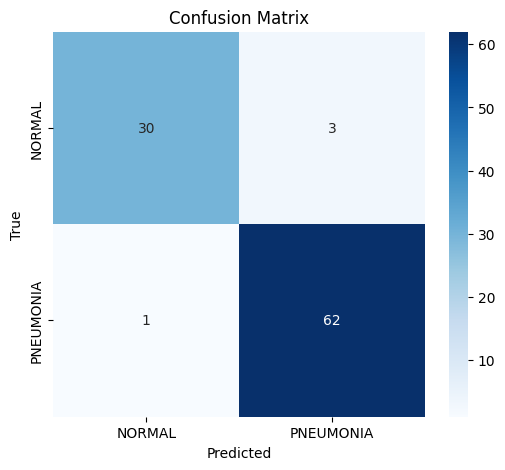

              precision    recall  f1-score   support

      NORMAL       0.97      0.91      0.94        33
   PNEUMONIA       0.95      0.98      0.97        63

    accuracy                           0.96        96
   macro avg       0.96      0.95      0.95        96
weighted avg       0.96      0.96      0.96        96



In [12]:

from sklearn.metrics import confusion_matrix
import seaborn as sns
class_labels = list(test_generator.class_indices.keys())
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# 4. Get the classification report
from sklearn.metrics import classification_report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

# ~ ROC Curve

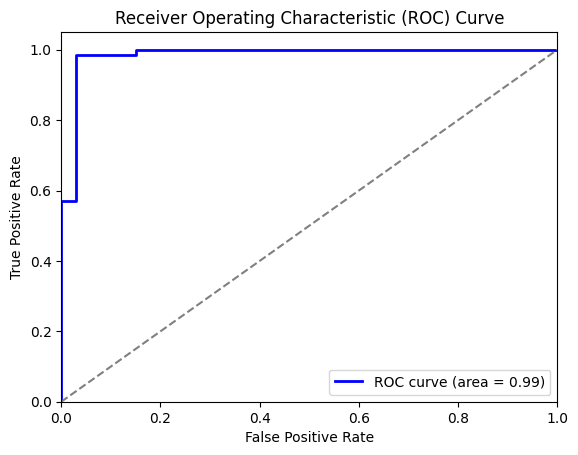

In [33]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

predictions = model.predict(test_generator, steps=test_generator.samples // batch_size)
pred_probabilities = predictions.ravel()  

fpr, tpr, thresholds = roc_curve(true_classes, pred_probabilities)

roc_auc = auc(fpr, tpr)

# Plottig ROC curve
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


# ~Predictions on Sample Test Images

1/1 [==============================] - 0s 77ms/step


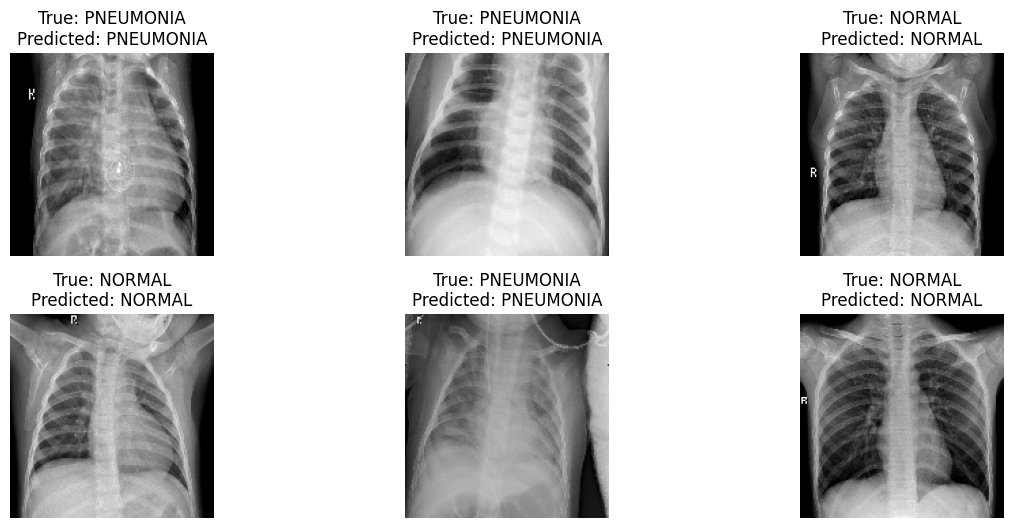

In [35]:
# Get a batch with mixed class labels
viz_generator = val_generator
images, labels = next(viz_generator)

# Make predictions
predictions = model.predict(images)
predicted_classes = (predictions > 0.5).astype("int32").flatten()

# Class labels
class_labels = list(viz_generator.class_indices.keys())

# Plot a few random images with predictions
plt.figure(figsize=(12, 8))
for i in range(min(6, len(images))):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].reshape(150, 150), cmap='gray')
    true_label = class_labels[int(labels[i])]
    predicted_label = class_labels[predicted_classes[i]]
    plt.title("True: " + true_label + "\nPredicted: " + predicted_label)
    plt.axis('off')
plt.tight_layout()
plt.show()


# ~CONCLUSION

The CNN model was trained for 10 epochs with a batch size of 16 on grayscale chest X-ray images of size 150×150.
During training, it achieved a final training accuracy of 93.77% and a validation accuracy of 92.86%. Upon evaluation on the unseen test set, the model achieved an impressive test accuracy of 95.83%, demonstrating its strong ability to predict pneumonia in chest X-ray images.

